In [1]:
import mediapipe as mp
import cv2
import numpy as np
import skatePoseModule as spm
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import random

In [2]:
psd = spm.poseDetector(min_detection_confidence=0.8, min_tracking_confidence=0.5, model_complexity=2)

In [3]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [188]:
cap = cv2.VideoCapture('./kakao/9_26_26.mp4')

w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
delay = round(1000/fps)

In [189]:
# Landmark List([idx,x,y,z])
# 전 영역의 랜드마크가 찍히지 않더라도 적당히 예상해 저장됨
# 단, 랜드마크가 하나도 찍히지 않은 프레임에 한해서는 저장되지 않음
lmlist = []

# 왼/오른다리 각도 List
# 0~180 사이의 정수가 저장됨
lmlist = []
rightLegAngleList = []
leftLegAngleList = []
rightGolbanAngleList = []
leftGolbanAngleList = []
visibility = []

cannotFind = []
cannotFind_ = 0

with mp_pose.Pose(min_detection_confidence=0.6, min_tracking_confidence=0.8, model_complexity=2) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break
         
        # BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # RGB to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass
        
#         mp_drawing.plot_landmarks(
#         results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

        # Save landmarks
        if results.pose_landmarks is not None:
            mypose = results.pose_landmarks
            tmpList = []
            for idx,lm in enumerate(mypose.landmark):
                
                point=np.array([int(idx), lm.x, lm.y, lm.z])
                tmpList.append(point)
                visibility.append(lm.visibility)
                
            rightLegAngleList.append(psd.findAngle3D(tmpList[24][1:],tmpList[26][1:],tmpList[28][1:]))
            leftLegAngleList.append(psd.findAngle3D(tmpList[23][1:],tmpList[25][1:],tmpList[27][1:]))
            rightGolbanAngleList.append(psd.findAngle3D(tmpList[12][1:],tmpList[24][1:],tmpList[26][1:]))
            leftGolbanAngleList.append(psd.findAngle3D(tmpList[11][1:],tmpList[23][1:],tmpList[25][1:]))    
            
            lmlist.append(tmpList)
        
        else:
            cannotFind_ += 1
            
            # Calc Leg Angles
#             rightLegAngleList.append(psd.findAngle3D(tmpList[23][1:],tmpList[25][1:],tmpList[27][1:]))
#             leftLegAngleList.append(psd.findAngle3D(tmpList[24][1:],tmpList[26][1:],tmpList[28][1:]))
            
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )  

        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            image1 = image
            break
            
    cap.release()
    cv2.destroyAllWindows()

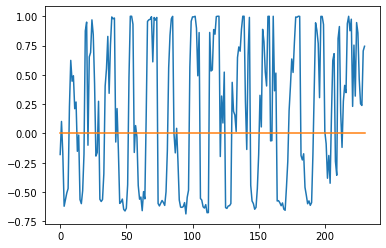

In [190]:
import math

leftList = (np.array(leftGolbanAngleList) + np.array(leftLegAngleList))
rightList = (np.array(rightGolbanAngleList) + np.array(rightLegAngleList))
GLList = np.tanh((leftList / rightList)-1)

import matplotlib.pyplot as plt

start = 0
end = len(GLList)
y = range(start, end)
plt.plot(y, np.array(GLList)[start:end])
plt.plot(y, np.zeros_like(np.array(GLList)[start:end]))
plt.show()

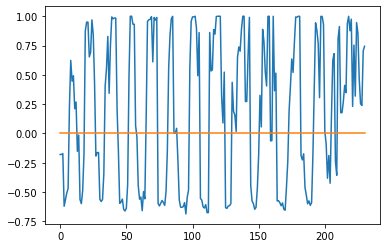

In [191]:
List = []
for i in range(len(GLList)-1):
    if i!=0:
        if (GLList[i-1] * GLList[i]) < 0 and (GLList[i] * GLList[i+1]) < 0:
            diff = GLList[i-1] - GLList[i]
            GLList[i] += diff
        
start = 0
end = len(GLList)
y = range(start, end)
plt.plot(y, np.array(GLList)[start:end])
plt.plot(y, np.zeros_like(np.array(GLList)[start:end]))
plt.show()

In [195]:
plus = 0

countList = []
onSwing = 0
flag = 0
hoit = 0

cnt = 0

oneSwingCnt_max = 0

if GLList[0] < 0:
    flag = 1
else:
    flag = 0

for i in range(len(GLList)-2):
    if flag==1:
        if GLList[i] < 0:
            onSwing = onSwing + 1
            mibun = GLList[i] * GLList[i+1]
            if onSwing >= 3 and mibun < 0:
                flag = 0
                cnt+=1
                if(oneSwingCnt_max < onSwing):
                    oneSwingCnt_max = onSwing
                onSwing = 0
    elif flag==0:
        if GLList[i] > 0:
            onSwing = onSwing + 1
            mibun = GLList[i] * GLList[i+1]
            if onSwing >= 3 and mibun < 0:
                flag = 1
                cnt+=1
                if(oneSwingCnt_max < onSwing):
                    oneSwingCnt_max = onSwing
                onSwing = 0
               
# 사람 자체가 잡히지 않았을 수 있는 파트 보정
plus_ = int(cannotFind_ / oneSwingCnt_max)             
cnt += plus_

print(cnt)

26
